In [14]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter

import warnings
warnings.filterwarnings('ignore')

## Functions

In [15]:
def binner(x):
    if x == 1:
        return "a - 1 session"
    elif x < 10:
        return chr(x + 96) + " - " + str(x) + ' sessions'
    elif x < 20:
        return "k - 10 - 20 - sessions"
    elif x < 30:
        return "l - 20 - 30 - sessions"
    elif x < 50:
        return "m - 30 - 50 - sessions"
    elif x < 100:
        return "n - 50 - 100 - sessions"
    else:
        return "o - 100+ - sessions"

In [128]:
def clean_dataframe(df, subset='pct_power_clients'):
    
    ndf = df.dropna(subset=[subset])
    ndf = ndf.drop_duplicates()
    
    return ndf

def assign_content_type(node_id):
    
    node_id = str(node_id).rstrip('.0')
    
    if node_id in info_dic.keys():
        return info_dic[int(node_id)]
    else:
        print(node_id)


### Run the following queries to start

Notes on running queries:
    
    I ran each of the queries separately in the database using DataGrip. We ultimately used a time period of 3 months as some of the queries (page_query) take too long to run otherwise. Remove the "\" when running the queries. 

In [97]:
# get additional information on webpages
info = pd.read_csv('all_node_info.csv')
info = info.dropna()
info = info.drop_duplicates()

In [98]:
info.columns

Index(['node_id', 'node_org', 'content_type'], dtype='object')

In [89]:
26021 in info.node_id

True

In [19]:
# Get client_id for all clients have more than 3 sessions
client_full_query = "SELECT client_id, count(*) as sessions \
                FROM ga_client \
                GROUP BY client_id"
client_full_df = pd.read_csv('client_full_query.csv')
client_full_df.columns, client_full_df.shape

(Index(['client_id', 'sessions'], dtype='object'), (18449014, 2))

In [20]:
# Get data on views from clients that have more than 10 sessions
page_query = "select \
          drupal_node.node_id, \
          sum(ga_session_views.pageviews) as pageviews, \
          count(DISTINCT ga_client.session_id) as sessions, \
          count(DISTINCT ga_client.client_id) as clients, \
          content_type, \
           title \
         from ga_session_views \
         INNER JOIN ga_client on ga_client.session_id = ga_session_views.session_id \
         LEFT OUTER JOIN drupal_node on drupal_node.node_id = ga_session_views.node_id \
         where client_id IN ( \
         with a as ( \
         SELECT client_id, count(*) as sessions \
         FROM ga_client \
         GROUP BY client_id HAVING count(*) > 10) \
         select client_id FROM a) \
         GROUP BY drupal_node.node_id, content_type,title"
page_df = pd.read_csv('pagequery3mos.csv')

In [21]:
page_df.columns, page_df.shape

(Index(['node_id', 'pageviews', 'sessions', 'clients', 'content_type', 'title'], dtype='object'),
 (28626, 6))

In [22]:
# Get all views for pages
full_page_query = "select \
          drupal_node.node_id, \
          sum(ga_session_views.pageviews) as pageviews, \
          count(DISTINCT ga_client.session_id) as sessions, \
          count(DISTINCT ga_client.client_id) as clients, \
          content_type, \
          title \
           from ga_session_views \
           INNER JOIN ga_client on ga_client.session_id = ga_session_views.session_id \
              LEFT OUTER JOIN drupal_node on drupal_node.node_id = ga_session_views.node_id \
            GROUP BY drupal_node.node_id, content_type,title"
full_page_df = pd.read_csv('fullpagequery3mos.csv')

In [23]:
full_page_df.columns, full_page_df.shape

(Index(['node_id', 'pageviews', 'sessions', 'clients', 'content_type', 'title'], dtype='object'),
 (33650, 6))

In [24]:
# Get overview of client behavior
summary_df = client_full_df.groupby(by='sessions').count().reset_index().rename(columns={'client_id':'clients'})
summary_df['total_visits'] = summary_df.clients * summary_df.sessions
summary_df['pct_of_total'] = summary_df.total_visits / sum(summary_df.total_visits)
summary_df['cumul_pct'] = summary_df.pct_of_total.cumsum() * 100
summary_df['bins'] = summary_df.sessions.apply(lambda x:binner(x))

In [25]:
summary_df.columns

Index(['sessions', 'clients', 'total_visits', 'pct_of_total', 'cumul_pct',
       'bins'],
      dtype='object')

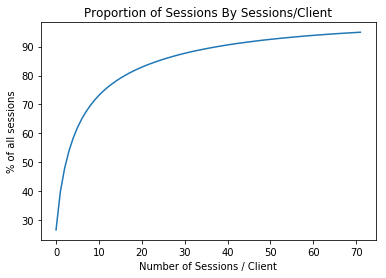

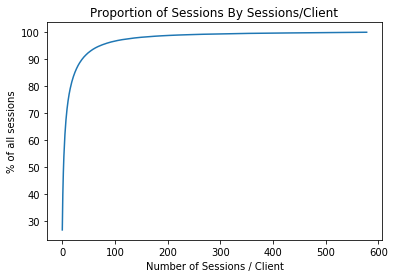

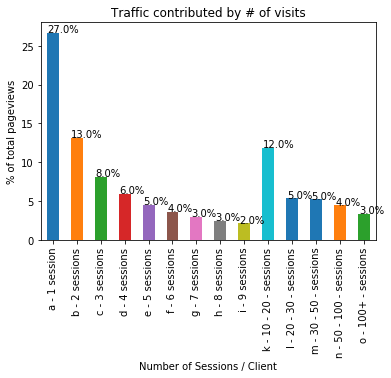

In [26]:
# Print proportions up to 95
summary_df.loc[summary_df.cumul_pct < 95,'cumul_pct'].plot()
plt.xlabel('Number of Sessions / Client')
plt.ylabel('% of all sessions')
plt.title('Proportion of Sessions By Sessions/Client')
plt.legend().remove()
plt.show()
summary_df.cumul_pct.plot()

# Print full
plt.xlabel('Number of Sessions / Client')
plt.ylabel('% of all sessions')
plt.title('Proportion of Sessions By Sessions/Client')
plt.legend().remove()
plt.show()

# Print binned sessions
bin_grouped = summary_df.groupby(by='bins').sum().reset_index()
bin_grouped['pct_total'] = bin_grouped['total_visits'] / bin_grouped.total_visits.sum() * 100
ax = bin_grouped.plot(kind='bar',x='bins',y='pct_total')
plt.legend().remove()
plt.xlabel('Number of Sessions / Client')
for p in ax.patches:
    ax.annotate(str(round(p.get_height())) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))
plt.ylabel("% of total pageviews")
plt.title("Traffic contributed by # of visits")
plt.show()

In [27]:
# Get feedback for all pages
full_page_feedback_query = "select \
          drupal_node.node_id, \
          sum(ga_session_views.pageviews) as pageviews, \
          count(DISTINCT ga_client.session_id) as sessions, \
          count(DISTINCT ga_client.client_id) as clients, \
          content_type, \
          title, \
          ga_session_views.node_id, \
          yes_rate, \
          total_feedback \
           from ga_session_views \
           INNER JOIN ga_client on ga_client.session_id = ga_session_views.session_id \
              LEFT OUTER JOIN drupal_node on drupal_node.node_id = ga_session_views.node_id \
              LEFT OUTER JOIN (select node_id, count(CASE WHEN info_found THEN 1 END)/cast(count(*) as FLOAT) as yes_rate, \
                      count(*) as total_feedback from formstack_pilot GROUP BY node_id) as feedback on feedback.node_id = ga_session_views.node_id \
            GROUP BY drupal_node.node_id, content_type,title, ga_session_views.node_id, yes_rate, total_feedback"
full_page_feedback_df = pd.read_csv('full_page_feedback_query.csv')

In [28]:
full_page_feedback_df.columns, full_page_feedback_df.shape

(Index(['node_id', 'pageviews', 'sessions', 'clients', 'content_type', 'title',
        'node_id.1', 'yes_rate', 'total_feedback'],
       dtype='object'), (35238, 9))

In [29]:
# Merge power with non-power
merged_df = full_page_df.merge(page_df, how='outer',left_on = 'node_id', right_on = 'node_id', suffixes=('_all', '_power'))

In [30]:
merged_df.shape, merged_df.columns

((33650, 11), Index(['node_id', 'pageviews_all', 'sessions_all', 'clients_all',
        'content_type_all', 'title_all', 'pageviews_power', 'sessions_power',
        'clients_power', 'content_type_power', 'title_power'],
       dtype='object'))

In [31]:
# Get percent totals and non power totals
summed_pageviews_all = merged_df['pageviews_all'].sum()
print(summed_pageviews_all)

merged_df['pct_power_pageviews'] = merged_df['pageviews_power'] / merged_df['pageviews_all'] * 100
merged_df['pct_power_clients'] = merged_df['clients_power'] / merged_df['clients_all'] * 100
merged_df['pct_power_sessions'] = merged_df['sessions_power'] / merged_df['sessions_all'] * 100
merged_df['non_power_sessions'] = merged_df['sessions_all'] - merged_df['sessions_power']
merged_df['non_power_clients'] = merged_df['clients_all'] - merged_df['clients_power']
merged_df['non_power_pageviews'] = merged_df['pageviews_all'] - merged_df['pageviews_power']

merged_df['pageviews_pct'] = merged_df['pageviews_all'] / summed_pageviews_all

# Build cumulative percentage
merged_df = merged_df.sort_values(by='pageviews_all',ascending=False)
merged_df['cumulative_pct_pageviews'] = merged_df.pageviews_pct.cumsum()

merged_df['power_views_per_session'] = merged_df['pageviews_power'] / merged_df['sessions_power']
merged_df['power_sessions_per_client'] = merged_df['sessions_power'] / merged_df['clients_power']
merged_df['non_power_views_per_session'] = merged_df['non_power_pageviews'] / merged_df['non_power_sessions']
merged_df['non_power_sessions_per_client'] = merged_df['non_power_sessions'] / merged_df['non_power_clients']

35360431


In [32]:
top_pages = merged_df[merged_df['cumulative_pct_pageviews'] < .8]

In [33]:
print(np.nansum(top_pages['sessions_power']) / np.nansum(top_pages['clients_power']))
print(np.nansum(top_pages['pageviews_power']) / np.nansum(top_pages['sessions_power']))
print(np.nansum(top_pages['non_power_sessions']) / np.nansum(top_pages['non_power_clients']))
print(np.nansum(top_pages['non_power_pageviews']) / np.nansum(top_pages['non_power_sessions']))
print("medians")
print((top_pages['pageviews_power'] / top_pages['sessions_power']).median())
print((top_pages['non_power_pageviews'] / top_pages['non_power_sessions']).median())
print("pageviews")
print((top_pages['non_power_pageviews'] / top_pages['non_power_sessions']).median())
print((top_pages['pageviews_power'] / top_pages['sessions_power']).median())

(top_pages['pageviews_power'] / top_pages['sessions_power'] - top_pages['non_power_pageviews'] / top_pages['non_power_sessions']).median()
(top_pages['sessions_power'] / top_pages['clients_power'] - top_pages['non_power_sessions'] / top_pages['non_power_clients']).median()

2.122211596306053
1.389250668872295
1.1625394396075703
1.3632795580371557
medians
1.3783830078794108
1.3530218481036602
pageviews
1.3530218481036602
1.3783830078794108


0.2795358817258009

In [34]:
# Subset full df with top X %
key_cols = ['pct_power_clients','pct_power_sessions','pct_power_pageviews','node_id','pageviews_power','non_power_pageviews','title_power','pageviews_all']
important_pages = merged_df[merged_df['cumulative_pct_pageviews'] < .99]
important_pages = important_pages[key_cols].sort_values(by='pct_power_pageviews',ascending=False)

In [35]:
# Get node data
node_query = "SELECT drupal_node_org.name as org_name,drupal_node.node_id, node_path, \
    yes_rate, \
total_feedback \
      from drupal_node \
    inner join drupal_author on drupal_node.author_uuid = drupal_author.author_uuid \
      inner join drupal_node_org on drupal_author.org_uuid = drupal_node_org.org_uuid \
    left outer join drupal_node_path on drupal_node.node_id = drupal_node_path.node_id \
 LEFT OUTER JOIN (select node_id, count(CASE WHEN info_found THEN 1 END)/cast(count(*) as FLOAT) as yes_rate, \
 count(*) as total_feedback from formstack_pilot GROUP BY node_id) as feedback on feedback.node_id = drupal_node.node_id\
    WHERE drupal_node.node_id in ("

node_query += ",".join([str(round(x,0)) for x in important_pages['node_id'].tolist() if pd.isnull(x) == False]) + ')'
print(node_query)
node_df = pd.read_csv('node_query.csv')

SELECT drupal_node_org.name as org_name,drupal_node.node_id, node_path,     yes_rate, total_feedback       from drupal_node     inner join drupal_author on drupal_node.author_uuid = drupal_author.author_uuid       inner join drupal_node_org on drupal_author.org_uuid = drupal_node_org.org_uuid     left outer join drupal_node_path on drupal_node.node_id = drupal_node_path.node_id  LEFT OUTER JOIN (select node_id, count(CASE WHEN info_found THEN 1 END)/cast(count(*) as FLOAT) as yes_rate,  count(*) as total_feedback from formstack_pilot GROUP BY node_id) as feedback on feedback.node_id = drupal_node.node_id    WHERE drupal_node.node_id in (72661.0,55611.0,52191.0,313306.0,55366.0,149421.0,275476.0,239906.0,33686.0,33751.0,135796.0,35906.0,110786.0,55371.0,239681.0,224436.0,35411.0,57741.0,130271.0,33431.0,151261.0,60966.0,186951.0,33756.0,296481.0,33656.0,241311.0,143786.0,128681.0,235326.0,35781.0,35266.0,224036.0,22396.0,6551.0,139811.0,33696.0,265526.0,231946.0,64946.0,340201.0,224506.

In [37]:
full_important_df = important_pages

In [40]:
full_important_df.columns

Index(['pct_power_clients', 'pct_power_sessions', 'pct_power_pageviews',
       'node_id', 'pageviews_power', 'non_power_pageviews', 'title_power',
       'pageviews_all'],
      dtype='object')

## Clean and format output

In [127]:
x = full_important_df.copy()

In [120]:
info_dic = {}
for i, r in info.iterrows():
    info_dic[r.node_id] = r['content_type']

In [152]:
def clean_dataframe(df, subset='pct_power_clients'):
    
    ndf = df.dropna(subset=[subset])
    ndf = ndf.drop_duplicates()
    
    return ndf

def assign_content_type(node_id):
    
    c = 0
    node_id = str(node_id).rstrip('.0')
    
    try:
        return info_dic[int(node_id)]
    except:
        return "N/A"



In [153]:
yest = pd.read_csv('0808.csv')

In [154]:
yest = yest.drop_duplicates()

In [155]:
yest['content_type'] = yest['node_id'].apply(assign_content_type,)

In [151]:
yest.content_type.unique()

array(['how_to_page', 'org_page', 'service_details', 'curated_list',
       'rules', 'news', 'service_page', 'regulation', 'guide_page',
       'decision', 'binder', 'info_details', 'form_page', 'event',
       'alert', 'advisory', 'topic_page', 'location_details', 'location',
       'executive_order', 'N/A', 'person', 'stacked_layout', 'action',
       'page', 'interstitial', 'error_page', 'decision_tree'],
      dtype=object)

In [156]:
yest.columns

Index(['Unnamed: 0', 'pct_power_clients', 'pct_power_sessions',
       'pct_power_pageviews', 'node_id', 'pageviews_power',
       'non_power_pageviews', 'title_power', 'pageviews_all', 'org_name',
       'node_path', 'yes_rate', 'total_feedback', 'content_type'],
      dtype='object')

In [157]:
yest.to_csv('with_content_type_0808')

In [159]:
yest.columns

Index(['Unnamed: 0', 'pct_power_clients', 'pct_power_sessions',
       'pct_power_pageviews', 'node_id', 'pageviews_power',
       'non_power_pageviews', 'title_power', 'pageviews_all', 'org_name',
       'node_path', 'yes_rate', 'total_feedback', 'content_type'],
      dtype='object')